In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.image as img
import json

In [23]:
""" Classes for displaying COVID-19 statistics per state in the 
United States. """

class Stats:
    def __init__(self, state, currmo, lastmo, curryear=23, lastyear=23):
        """Calculating and displaying COVID-19 statistics per state.

        Attributes:
            data (list): list of CSV files and URL links
            firstdate (str): date generated from 'currmo' and 'curryear'
            seconddate (str): date generated from 'lastmo' and 'lastyear'
            datesDF (DataFrame): DataFrame storing COVID-19 data for one chosen state
            allstats (list): list containing COVID-19 data that will be used for Graph objects
            finalcases (list): list containing case rates for each US state
            finaldeaths (list): list containing death rates for each US state
            finaldates (list): list containing dates for each US state
            finalstates (list): list containing each US state
            loadData() (method): method where the script begins

        Side effects:
            after initialization, loadData() method is called to begin script
        """

        self.data = ["../../../Documents/GitHub/covid-19-data/us-states.csv","nst-est2020.csv","states-sqmi20.csv","https://data.cdc.gov/resource/unsk-b7fc.json","abbr.csv"]
        self.state = state
        self.currmo = currmo
        self.lastmo = lastmo
        self.curryear = curryear
        self.lastyear = lastyear

        self.firstdate = None
        self.seconddate = None
        self.datesDF = pd.DataFrame()
        self.allstats = []
        self.finalcases = []
        self.finaldeaths = []
        self.finaldates = []
        self.finalstates = []
        self.loadData()

    def vax(self):
        """Generates a DataFrame object displaying vaccinations rates per state.

        Side effects:
            makes a request to an API and creates a DataFrame object, 
            loads DataFrame from local computer, saves DataFrame to local computer

        Raises:
            general exception which checks if a file exists and if it can be read,
            exception prints a message to the console and allows the method to continue 
            and generate a new DataFrame

        Returns:
            popvaxxed (DataFrame):  contains the name and abbreviations of 
            each state, fully vaccinated numbers and percentages of vaccination 
            rates, current population per rate
            totalvaxx (float):  percent of fully vaccinated per state, the sum 
            of fully_vaccinated divided by the sum of curr_pop
        """

        today = datetime.date.today().isoformat()

        try:
            popvaxxed = pd.read_csv(today+"_"+"popvaxxed.csv")
            totalvaxx=popvaxxed['fully_vaccinated'].astype('int64').sum()/popvaxxed['curr_pop'].sum()
            return popvaxxed, totalvaxx
        except:
            print("Grabbing latest vaccination data...")

        pop2=pd.read_csv(self.data[1])
        vaxxURL=self.data[3]
        CDCdata=requests.get(vaxxURL)
        statesvaxx=pd.DataFrame.from_records(data=CDCdata.json())
        statesvaxx=statesvaxx[['date','location','series_complete_yes']]
        statesvaxx.columns=['date','location','fully_vaccinated']
        statesvaxx.loc[:,'date']=statesvaxx['date'].apply(lambda x: 
                                                          datetime.datetime.strptime(
                                                              x,'%Y-%m-%dT%H:%M:%S.000'
                                                          ).strftime('%Y-%m-%d'))
        statesvaxx.loc[:,'day']=statesvaxx['date'].apply(lambda x: 
                                                         datetime.datetime.strptime(
                                                             x,'%Y-%m-%d').strftime('%d'))
        statesvaxx=statesvaxx.groupby('location')['fully_vaccinated'].agg('last').reset_index()
        statesvaxx=statesvaxx[(statesvaxx['location']!='AS') 
                              & (statesvaxx['location']!='BP2') 
                              & (statesvaxx['location']!='DD2') 
                              & (statesvaxx['location']!='FM') 
                              & (statesvaxx['location']!='GU') 
                              & (statesvaxx['location']!='IH2') 
                              & (statesvaxx['location']!='LTC') 
                              & (statesvaxx['location']!='MP')
                              & (statesvaxx['location']!='PW')
                              & (statesvaxx['location']!='RP') 
                              & (statesvaxx['location']!='US') 
                              & (statesvaxx['location']!='VA2') 
                              & (statesvaxx['location']!='VI')].reset_index(drop=True)
        pop2.columns=['SUMLEV', 'REGION', 'DIVISION', 'state', 'name', 'CENSUS2010POP',
               'ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011',
               'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
               'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
               'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE042020',
               'pop2020']
        pop2=pop2[['name','pop2020']].iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
                                            ,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
                                            ,37,38,39,40,41,42,43,56,44,45,46,47,48,49,50
                                            ,51,52,53,54,55]].reset_index(drop=True)
        pop2=pop2.iloc[[1,0,3,2,4,5,6,8,7,9,10,11,15,12,13,14,16,17,18,21,20,19,22,23,25
                        ,24,26,33,34,27,29,30,31,28,32,35,36,37,38,39,40,41,42,43,44,45
                        ,47,46,48,50,49,51]].reset_index(drop=True)
        statesvaxx=statesvaxx.drop([22]).reset_index(drop=True)
        popvaxxed=pd.concat([statesvaxx,pop2],axis=1)
        popvaxxed.columns=['abbr','fully_vaccinated','full_name','curr_pop']
        popvaxxed.loc[:,'percent']=round((popvaxxed['fully_vaccinated']
                                          .astype('int64')/popvaxxed['curr_pop'])*100,2)
        totalvaxx=popvaxxed['fully_vaccinated'].astype('int64').sum()/popvaxxed['curr_pop'].sum()
        popvaxxed.to_csv(today+"_"+"popvaxxed.csv",index=False)

        return popvaxxed, totalvaxx

    def all_time(self):
        """Generates a DataFrame object that contains the latest 
        aggregated COVID-19 data

        Side effects:
            loads DataFrame from local computer, saves DataFrame to local computer,
        
        Raises:
            general exception which checks if a file exists and if it can be read, 
            exception prints a message to the console and allows the method to continue 
            and generate a new DataFrame

        Returns:
            bothDF (DataFrame):  contains aggregated data which includes 
            recorded cases, deaths, total population, people per square mile,
            total square miles, case fatality, and incidence rates per state,
            organized by latest date available
        """

        today = datetime.date.today().isoformat()

        try:
            bothDF = pd.read_csv(today+"_"+"bothDF.csv")
            return bothDF
        except:
            print("Grabbing all state COVID-19 data...")

        df=pd.read_csv(self.data[0])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        bothDF=df.merge(pop)
        states_sqmi=pd.read_csv(self.data[2])
        bothDF=bothDF.merge(states_sqmi,left_on='state',right_on='states')
        bothDF=bothDF.groupby('state')[[
            'cases','deaths','day','month','year','POP2020','ppsm','sq_mi']].agg('last').reset_index()
        bothDF.loc[:,'case_fatality']=round((bothDF['deaths']/bothDF['cases'])*100,3)
        bothDF.loc[:,'incidence_rate']=round((bothDF['cases']/bothDF['POP2020'])*100000,3)
        bothDF.to_csv(today+"_"+"bothDF.csv",index=False)

        return bothDF

    def getDF(self):
        """Generates a DataFrame object used when beginning the script

        Side effects:
            loads DataFrame from local computer, saves DataFrame to local computer,
            deletes DataFrame from local computer, prints messages to console

        Raises:
            general exception which checks if a file exists and if it can be read,
            exception prints a message to the console and allows the method to continue 
            and generate a new DataFrame

        Returns:
            df (DataFrame):  contains COVID-19 data for each US state which 
            includes recorded cases, deaths, and total population per state, 
            organized by first recorded date to most recent
        """

        today = datetime.date.today().isoformat()

        try:
            df = pd.read_csv(today+"_"+"df.csv")
            return df
        except:
            #file = today+"_"+"df.csv"
            #if(os.path.exists(file) and os.path.isfile(file)):
            #    os.remove(file)
            #    print(today+"_"+"df.csv"+" deleted.")
            #    print("Grabbing latest COVID-19 information.")
            #else:
            #    print("Remember to pull latest updates from GitHub, grabbing + "
            #          "latest COVID-19 information.")
            print("Remember to pull latest updates from GitHub, grabbing latest COVID-19 information.")

        df=pd.read_csv(self.data[0])
        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        sqmi=pd.read_csv(self.data[2])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        df=df.merge(pop)
        abbr=pd.read_csv(self.data[4])
        df=df.merge(abbr, left_on='state',right_on='full_name')

        df.to_csv(today+"_"+"df.csv",index=False)

        return df

    def calculateDF(self, df, state):
        """Generates DataFrame objects using information provided by
        the user

        Args:
            df (DataFrame):  DataFrame object with information needed to 
            generate a new DataFrame
            state (str):  name of US state used as a filter to gather
            relevant information

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None

        Attributes:
            self.lastyear, self.curryear, self.lastmo, and self.currmo 
            are referenced to obtain new DataFrame objects

        Returns:
            firstdf (DataFrame):  DataFrame is constructed and organized 
            by name for each US state and the dates provided by the user
        """

        yearCount = []
        yearNum = self.lastyear
        moNum = self.lastmo
        countNum = 0

        if self.curryear == self.lastyear:
            if self.currmo == self.lastmo:
                firstdf = df[(df['state'] == state) & (df['month'] == self.currmo) & (df['year'] == self.curryear)]

            elif self.currmo > self.lastmo:
                
                firstdf = df[(df['state'] == state) & (df['month'] <= self.currmo) & (df['month'] >=self.lastmo) & (df['year'] == self.lastyear)]

            else:
                print("'lastmo' cannot be greater than 'currmo'.")
                return None

        elif self.curryear > self.lastyear:
            if self.currmo == self.lastmo:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        if self.lastmo == 12:
                            yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum) & (df['month'] == self.lastmo)])
                        else:
                            yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum) & (df['month'] >= self.lastmo)])
                    else:
                        yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum)])
                    yearNum += 1
                    countNum += 1

                yearCount[-1] = df[(df['state'] == state) & (df['year'] == self.curryear) & (df['month'] <= self.currmo)]

                countNum = 1
                firstdf = yearCount[0]

                for dfs in yearCount:
                    if countNum >= len(yearCount):
                        break
                    firstdf = firstdf.append(yearCount[countNum])
                    countNum += 1

            elif self.currmo < self.lastmo:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        if self.lastmo == 12:
                            yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum) & (df['month'] == self.lastmo)])
                        else:
                            yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum) & (df['month'] >= self.lastmo)])
                    else:
                        yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum)])
                    yearNum += 1
                    countNum += 1

                yearCount[-1] = df[(df['state'] == state) & (df['year'] == self.curryear) & (df['month'] <= self.currmo)]

                countNum = 1
                firstdf = yearCount[0]

                for dfs in yearCount:
                    if countNum >= len(yearCount):
                        break
                    firstdf = firstdf.append(yearCount[countNum])
                    countNum += 1

            else:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum) & (df['month'] >= self.lastmo)])
                    else:
                        yearCount.append(df[(df['state'] == state) & (df['year'] == yearNum)])

                    yearNum += 1
                    countNum += 1
                    
                countNum = 1
                yearCount[-1] = df[(df['state'] == state) & (df['year'] == self.curryear) & (df['month'] <= self.currmo)]
                
                countNum = 1
                firstdf = yearCount[0]

                for dfs in yearCount:
                    if countNum >= len(yearCount):
                        break
                    firstdf = firstdf.append(yearCount[countNum])
                    countNum += 1

        else:
            print("'lastyear' cannot be greater than 'curryear'.")
            return None

        return firstdf
    
    def calculateMonths(self):
        """Generates a list object containing values which represent
        each month found in current DataFrame object

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None
            
        Attributes:
            self.lastyear, self.curryear, self.lastmo, and self.currmo 
            are referenced to obtain new DataFrame objects

        Returns:
            getMonths (list):  contains integer values representing 
            each month to be used for visualization for Graph objects
        """

        yearCount = []
        getMonths = []
        yearNum = self.lastyear
        moNum = self.lastmo
        countNum = 0
        findDF = pd.DataFrame()
        
        if self.curryear == self.lastyear:
            if self.currmo == self.lastmo:
                getMonths.append(moNum)

            elif self.currmo > self.lastmo:
                if self.currmo == 12:
                    findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] >= moNum)]
                else:
                    findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] >= moNum) & (self.datesDF['month'] <= self.currmo)]
                for num in findDF['month'].unique().tolist():
                    getMonths.append(num)

            else:
                print("'lastmo' cannot be greater than 'currmo'.")
                return None

        elif self.curryear > self.lastyear:
            if self.currmo == self.lastmo:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        if self.lastmo == 12:
                            findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] == self.lastmo)]
                            for num in findDF['month'].unique().tolist():
                                getMonths.append(num)

                        else:
                            findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] >= self.lastmo)]
                            for num in findDF['month'].unique().tolist():
                                getMonths.append(num)

                    else:
                        findDF = self.datesDF[self.datesDF['year'] == yearNum]
                        for num in findDF['month'].unique().tolist():
                            getMonths.append(num)

                    getMonths.append(yearNum)
                    yearNum += 1
                    countNum += 1

            elif self.currmo < self.lastmo:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        if self.lastmo == 12:
                            findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] == self.lastmo)]
                            for num in findDF['month'].unique().tolist():
                                getMonths.append(num)

                        else:
                            findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] >= self.lastmo)]
                            for num in findDF['month'].unique().tolist():
                                getMonths.append(num)

                    else:
                        findDF = self.datesDF[self.datesDF['year'] == yearNum]
                        for num in findDF['month'].unique().tolist():
                            getMonths.append(num)

                    getMonths.append(yearNum)
                    yearNum += 1
                    countNum += 1

            else:
                while yearNum < self.curryear+1:
                    if countNum == 0:
                        findDF = self.datesDF[(self.datesDF['year'] == yearNum) & (self.datesDF['month'] >= self.lastmo)]
                        for num in findDF['month'].unique().tolist():
                            getMonths.append(num)

                    else:
                        findDF = self.datesDF[self.datesDF['year'] == yearNum]
                        for num in findDF['month'].unique().tolist():
                            getMonths.append(num)

                    getMonths.append(yearNum)
                    yearNum += 1
                    countNum += 1

        else:
            print("'lastyear' cannot be greater than 'curryear'.")
            return None

        return getMonths

    def startProgram(self):
        """Method that organizes DataFrames for each US state and calculates
        death and case rates

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None
            self.getDF() is called to obtain a DataFrame object
            self.calculateDF() is called to construct DataFrame objects
            to be used for graphing

        Attributes:
            self.finalcases, self.finaldeaths, self.finaldates, self.finalstates, 
            self.allstats are appended with information used for visualization 
            with Graph objects 
            self.allstates and self.state are referenced to obtain values
        """

        caseslst = []
        deathlst = []
        dateslst = []
        newDF = self.getDF()
        self.allstates = newDF['state'].unique().tolist()
        self.state = newDF[newDF['abbr'] == self.state].iloc[0]['state']
        getfirstDF = pd.DataFrame()

        for sts in self.allstates:
            while True:
                try:
                    if self.lastyear > 20:
                        if self.lastmo == 1:
                            getfirstDF = newDF[(newDF['state']==sts) & (newDF['month'] == 12) & (newDF['year'] == self.lastyear-1)].iloc[-1]
                        else:
                            getfirstDF = newDF[(newDF['state']==sts) & (newDF['month'] == self.lastmo-1) & (newDF['year'] == self.lastyear)].iloc[-1]
                    else:
                        if self.lastmo != 1:
                            getfirstDF = newDF[(newDF['state']==sts) & (newDF['month'] == self.lastmo-1) & (newDF['year'] == self.lastyear)].iloc[-1]

                except Exception as e:
                    print("error: ",e)
                    break
                break

            if self.curryear == self.lastyear:
                if self.currmo == self.lastmo:
                    if len(getfirstDF) < 1:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.reset_index(drop=True)
                    else:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.append(getfirstDF).reset_index(drop=True)

                elif self.currmo > self.lastmo:
                    if len(getfirstDF) < 1:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.reset_index(drop=True)
                    else:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.append(getfirstDF).reset_index(drop=True)
                else:
                    print("'lastmo' cannot be greater than 'currmo'.")
                    return None

            elif self.curryear > self.lastyear:
                if self.currmo == self.lastmo:
                    if len(getfirstDF) < 1:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.reset_index(drop=True)
                    else:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.append(getfirstDF).reset_index(drop=True)

                elif self.currmo < self.lastmo:
                    if len(getfirstDF) < 1:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.reset_index(drop=True)
                    else:
                        statsDF = self.calculateDF(newDF, sts)
                        statsDF = statsDF.append(getfirstDF).reset_index(drop=True)
                else:
                    if len(getfirstDF) < 1:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.reset_index(drop=True)
                    else:
                        statsDF = self.calculateDF(newDF,sts)
                        statsDF = statsDF.append(getfirstDF).reset_index(drop=True)

            else:
                print("'lastyear' cannot be greater than 'curryear'.")
                return None

            if len(statsDF) == 0:
                statsDF = newDF.copy(deep=False)
                continue

            casestats = statsDF['cases'].tolist()
            deathstats = statsDF['deaths'].tolist()
            datestats = statsDF['date'].tolist()

            for dates in datestats:
                dateslst.append(dates)

            count = 1
            for cases, deaths in zip(casestats, deathstats):
                caseslst.append(casestats[count] - casestats[count-1])
                deathlst.append(deathstats[count] - deathstats[count-1])
                count += 1
                if count >= len(statsDF):
                    break

            if len(getfirstDF) >= 1:
                firstcasecount = casestats[0] - getfirstDF[2]
                firstdeathcount = deathstats[0] - getfirstDF[3]
                caseslst.insert(0, firstcasecount)
                deathlst.insert(0, firstdeathcount)
                dateslst.pop()
                caseslst.pop()
                deathlst.pop()
            else:
                caseslst.insert(0, casestats[0])
                deathlst.insert(0, deathstats[0])

            self.finalcases.append(caseslst)
            self.finaldeaths.append(deathlst)
            self.finaldates.append(dateslst)
            self.finalstates.append(sts)

            if sts == self.state:
                self.allstats.append(sts)

            del casestats[:]
            del deathstats[:]
            del datestats[:]
            statsDF = newDF.copy(deep=False)
            caseslst = []
            deathlst = []
            dateslst = []

        self.allstats.append((self.finalcases,self.finaldeaths,self.finaldates,self.finalstates))

        return None

    def checkParameters(self):
        """Method that validates user entry of Stats object parameters

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None

        Attributes:
            self.currmo, self.lastmo, self.curryear, self.lastyear are 
            referenced for date validation

        Returns:
            check (bool):  a default value of True is returned if date validation
            passes each conditional, otherwise a value of None is returned
        """

        check = True
        latestMonth = datetime.date.today().isoformat()
        latestMonth = int(latestMonth[5:7])
        latestYear = datetime.date.today().isoformat()
        latestYear = int(latestYear[2:4])

        if self.lastmo < 1 or self.currmo < 1:
            print("Enter a valid month.")
            return None
        
        if self.lastmo > 12 or self.currmo > 12:
            print("Enter a valid month.")
            return None
        
        if self.lastyear < 20 or self.curryear < 20:
            print("Enter valid year.")
            return None

        if self.lastyear > latestYear or self.curryear > latestYear:
            print("Enter valid year.")
            return None
        
        if self.curryear == 23 and self.currmo > latestMonth:
            print("Enter valid month for current year.")
            return None

        if self.curryear == self.lastyear:
            if self.currmo == self.lastmo:
                return check
            elif self.currmo > self.lastmo:
                return check
            else:
                print("'lastmo' cannot be greater than 'currmo'.")
                return None

        elif self.curryear > self.lastyear:
            if self.currmo == self.lastmo:
                return check
            elif self.currmo < self.lastmo:
                return check
            else:
                return check

        else:
            print("'lastyear' cannot be greater than 'curryear'.")
            return None

        return check
    
    def monthlyStats(self):
        """Method that collects DataFrame information organized by month

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None
            self.CalculateMonths() is called to obtain a list of values

        Attributes:
            self.datesDF is referenced to obtain values

        Returns:
            countedMonths (list):  contains four values; first is the 
            current month being evaluated, second is the sum of COVID-19 
            deaths for that month, third is the sum of COVID-19 cases, 
            fourth is the average number of deaths, fifth is the average 
            number of cases
        """

        countedMonths = []
        checkYear = self.lastyear
        getMonths = self.calculateMonths()
        count = 0

        if self.curryear == self.lastyear:
            if self.currmo == self.lastmo:

                newStatsDF = self.datesDF[(self.datesDF['month'] == getMonths[0]) & (self.datesDF['year'] == self.lastyear)]
                firstdate = self.datesDF[['date','month','year']]
                firstdate = firstdate[(firstdate['month'] == getMonths[0]) & (firstdate['year'] == self.lastyear)].iloc[0]['date']

                countedMonths.append((firstdate,round(newStatsDF['deaths'].sum(),2),
                                      round(newStatsDF['cases'].sum(),2),
                                      round(newStatsDF['deaths'].sum()/len(newStatsDF['deaths']),2),
                                      round(newStatsDF['cases'].sum()/len(newStatsDF['cases']),2)))

            elif self.currmo > self.lastmo:

                while count < len(getMonths):
                    newStatsDF = self.datesDF[(self.datesDF['month'] == getMonths[count]) & (self.datesDF['year'] == checkYear)]
                    firstdate = self.datesDF[['date','month','year']]
                    firstdate = firstdate[(firstdate['month'] == getMonths[count]) & (firstdate['year'] == checkYear)].iloc[0]['date']

                    countedMonths.append((firstdate,round(newStatsDF['deaths'].sum(),2),
                                          round(newStatsDF['cases'].sum(),2),
                                          round(newStatsDF['deaths'].sum()/len(newStatsDF['deaths']),2),
                                          round(newStatsDF['cases'].sum()/len(newStatsDF['cases']),2)))
                    count += 1

            else:
                print("'lastmo' cannot be greater than 'currmo'.")
                return None

        elif self.curryear > self.lastyear:

            if self.currmo == self.lastmo:

                while count < len(getMonths):
                    if getMonths[count] == checkYear:
                        checkYear += 1
                        count += 1
                        continue
                    else:
                        newStatsDF = self.datesDF[(self.datesDF['month'] == getMonths[count]) & (self.datesDF['year'] == checkYear)]
                        firstdate = self.datesDF[['date','month','year']]
                        firstdate = firstdate[(firstdate['month'] == getMonths[count]) & (firstdate['year'] == checkYear)].iloc[0]['date']

                        countedMonths.append((firstdate,round(newStatsDF['deaths'].sum(),2),
                                              round(newStatsDF['cases'].sum(),2),
                                              round(newStatsDF['deaths'].sum()/len(newStatsDF['deaths']),2),
                                              round(newStatsDF['cases'].sum()/len(newStatsDF['cases']),2)))
                    count += 1

            elif self.currmo < self.lastmo:

                while count < len(getMonths):
                    if getMonths[count] == checkYear:
                        checkYear += 1
                        count += 1
                        continue
                    else:
                        newStatsDF = self.datesDF[(self.datesDF['month'] == getMonths[count]) & (self.datesDF['year'] == checkYear)]
                        firstdate = self.datesDF[['date','month','year']]
                        firstdate = firstdate[(firstdate['month'] == getMonths[count]) & (firstdate['year'] == checkYear)].iloc[0]['date']

                        countedMonths.append((firstdate,round(newStatsDF['deaths'].sum(),2),
                                              round(newStatsDF['cases'].sum(),2),
                                              round(newStatsDF['deaths'].sum()/len(newStatsDF['deaths']),2),
                                              round(newStatsDF['cases'].sum()/len(newStatsDF['cases']),2)))
                    count += 1

            else:
                while count < len(getMonths):
                    if getMonths[count] == checkYear:
                        checkYear += 1
                        count += 1
                        continue
                    else:
                        newStatsDF = self.datesDF[(self.datesDF['month'] == getMonths[count]) & (self.datesDF['year'] == checkYear)]
                        firstdate = self.datesDF[['date','month','year']]
                        firstdate = firstdate[(firstdate['month'] == getMonths[count]) & (firstdate['year'] == checkYear)].iloc[0]['date']

                        countedMonths.append((firstdate,round(newStatsDF['deaths'].sum(),2),
                                              round(newStatsDF['cases'].sum(),2),
                                              round(newStatsDF['deaths'].sum()/len(newStatsDF['deaths']),2),
                                              round(newStatsDF['cases'].sum()/len(newStatsDF['cases']),2)))
                    count += 1

        else:
            print("'lastyear' cannot be greater than 'curryear'.")
            return None

        return countedMonths

    def loadData(self):
        """Method that collects data obtained from other methods and loads
        them into lists to be used for visualization with Graph objects

        Side effects:
            self.checkParameters() is called for validation measures
            self.startProgram() is called to begin obtaining information
            for visualization using Graph objects
            self.getDF() is called to obtain a new Stats class DataFrame 
            object
            self.vax() is called to obtain a DataFrame and float value 
            containing vaccination information and US vaccination rate, 
            respectively
            self.all_time() is called to obtain a DataFrame which contains 
            aggregated COVID-19 information
            self.monthlyStats() is called to obtain COVID-19
            information by month
            statistics regarding the state chosen by user is printed
            at the end of the method call

        Attributes:
            self.datesDF is referenced to store state information chosen 
            by user
            self.firstdate and self.seconddate are referenced to store 
            dates
            self.allstats is appended with various objects used for 
            visualization with Graph objects

        Returns:
            None
        """

        if self.checkParameters() == None:
            return None
        else:
            self.startProgram()

        IRlst=[]
        CFRlst=[]
        avgCases=[]
        avgDeaths=[]
        totalCases=[]
        totalDeaths=[]
        foundstates = []
        newDF = self.getDF()

        for info in zip(self.finalcases, self.finaldeaths, self.finaldates, self.finalstates):
            if info[3] == self.state:
                self.datesDF = pd.DataFrame({'date':info[2],'cases':info[0],'deaths':info[1]})
            stats=newDF[newDF['state']==info[3]].reset_index(drop=True) # creates DF of each state
            IRlst.append(round((sum(info[0])/stats['POP2020'].iloc[0])*100000,3)) # IR stats appended to list
            CFRlst.append(round((sum(info[1])/sum(info[0]))*100,3)) # CFR stats appended to list
            avgCases.append(round(sum(info[0])/len(info[0]),2)) 
            avgDeaths.append(round(sum(info[1])/len(info[1]),2))
            totalCases.append(sum(info[0]))
            totalDeaths.append(sum(info[1]))
            foundstates.append(info[3])

        if len(self.datesDF) < 1:
            print(f"{self.state} not found.")
            return None

        if int(self.datesDF.iloc[0]['date'][5:7]) != self.lastmo:
            print("'self.lastmo' starting at "+str(int(self.datesDF.iloc[0]['date'][5:7]))+".")

        allStatesDF = pd.DataFrame({'full_name':foundstates,
                                    'total_cases':totalCases,'total_deaths':totalDeaths,
                                    'avg_cases':avgCases,'avg_deaths':avgDeaths,
                                    'cfr':CFRlst,'ir':IRlst})

        self.datesDF.loc[:,'day']=self.datesDF['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        self.datesDF.loc[:,'month']=self.datesDF['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        self.datesDF.loc[:,'year']=self.datesDF['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        self.datesDF=self.datesDF[['date','cases','deaths','day','month','year']]
        self.datesDF['day']=self.datesDF['day'].astype('int64')
        self.datesDF['month']=self.datesDF['month'].astype('int64')
        self.datesDF['year']=self.datesDF['year'].astype('int64')

        popvaxxed, totalVax = self.vax()
        allStatesDF = allStatesDF.merge(popvaxxed[['full_name','abbr','curr_pop','percent']],on='full_name')
        self.firstdate=datetime.datetime.strptime(self.datesDF.iloc[0]['date'],'%Y-%m-%d').strftime("%B %d '%y")
        self.seconddate=datetime.datetime.strptime(self.datesDF.iloc[-1]['date'],'%Y-%m-%d').strftime("%B %d '%y")

        allTime = self.all_time()
        countedMonths = self.monthlyStats()
        allTime.columns = ['state', 'all_cases', 'all_deaths', 'day', 'month', 'year', 'POP2020', 'ppsm',
       'sq_mi', 'all_case', 'all_incidence']
        allStatesDF = allStatesDF.merge(allTime[['state','all_cases','all_deaths',
                                                 'ppsm','sq_mi','all_case','all_incidence']],
                                                 left_on='full_name',right_on='state')
        stateDF = allStatesDF[allStatesDF['full_name'] == self.state]

        self.allstats.append(allStatesDF)
        self.allstats.append(stateDF)
        self.allstats.append(self.datesDF)
        self.allstats.append(countedMonths)
        self.allstats.append(totalVax)
        self.allstats.append((self.firstdate,self.seconddate))

        currYear = int(self.seconddate[-2:])
        lastYear = int(self.firstdate[-2:])
        if currYear == lastYear:
            self.firstdate = self.firstdate[:-4]

        display("State of "+self.state)
        avgRank=allStatesDF.sort_values(by='avg_cases',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="Average of {:,} cases per day in "+str(len(self.datesDF['date']))+" days, currently ranked #"+str(avgRank[0]+1)+" in the United States."                    
        display(txt.format(round(stateDF.iloc[0]['avg_cases'],2)))
        avgRank=allStatesDF.sort_values(by='avg_deaths',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="Average of {:,} deaths per day in "+str(len(self.datesDF['date']))+" days, currently ranked #"+str(avgRank[0]+1)+" in the United States."
        display(txt.format(round(stateDF.iloc[0]['avg_deaths'],2)))

        avgRank=allStatesDF.sort_values(by='cfr',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        display("Case Fatality Ratio from "+self.firstdate+" to "+self.seconddate+": "+str(stateDF.iloc[0]['cfr'])+"%, currently ranked #"+str(avgRank[0]+1)+" in the United States.")
        avgRank=allStatesDF.sort_values(by='ir',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="Incidence Rate from "+self.firstdate+" to "+self.seconddate+": {:,} per 100k, currently ranked #"+str(avgRank[0]+1)+" in the United States."
        display(txt.format(stateDF.iloc[0]['ir']))
        avgRank=allStatesDF.sort_values(by='total_cases',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="There have been {:,} cases from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
        display(txt.format(stateDF.iloc[0]['total_cases'],avgRank[0]+1))
        avgRank=allStatesDF.sort_values(by='total_deaths',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="There have been {:,} deaths from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
        display(txt.format(stateDF.iloc[0]['total_deaths'],avgRank[0]+1))

        avgRank=allStatesDF.sort_values(by='percent',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        display(self.state+" is "+str(stateDF.iloc[0]['percent'])+"% fully vaccinated, currently ranked #"+str(avgRank[0]+1)+" in the United States.")
        avgRank=allStatesDF.sort_values(by='curr_pop',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="Total population: {:,}, ranked #"+str(avgRank[0]+1)+" in the United States."
        display(txt.format(stateDF.iloc[0]['curr_pop']))
        avgRank=allStatesDF.sort_values(by='ppsm',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="There are {:,} people per square mile, ranked #"+str(avgRank[0]+1)+" in the United States." 
        display(txt.format(stateDF.iloc[0]['ppsm']))
        avgRank=allStatesDF.sort_values(by='sq_mi',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt=self.state+" has {:,} total square miles, ranking #"+str(avgRank[0]+1)+" in the United States."
        display(txt.format(stateDF.iloc[0]['sq_mi']))
        avgRank=allStatesDF.sort_values(by='all_case',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        display("All Time Case Fatality Ratio: "+str(stateDF.iloc[0]['all_case'])+"%, currently ranked #"+str(avgRank[0]+1)+" in the United States.")
        avgRank=allStatesDF.sort_values(by='all_incidence',ascending=False).reset_index(drop=True)
        avgRank=avgRank.index[avgRank['full_name'] == self.state]
        txt="All Time Incidence Rate: {:,} per 100k, currently ranked #"+str(avgRank[0]+1)+" in the United States."
        display(txt.format(stateDF.iloc[0]['all_incidence']))
        display(round(self.datesDF[['cases','deaths']].describe().T,2))

        return None

In [24]:
class Graph:
    """ Visualizations for Stats objects.

        Side effects:
            displays text and various charts to the console

        """

    def __init__(self, data):
        self.data = data

        print("~~Stats to graph~~")
        print("'info', 'monthly', 'averages', 'totals', 'cfrir', 'vax'")
        print()

    def getPoints(self, allVal, minY, maxY, x, y):
        """Method that obtains data points used for graphing

        Args:
            allVal (numpy array 2D):  Stats DataFrame object info; 
            'date', 'deaths' or 'cases'
            minY (float):  minimum value of 'cases' or 'deaths'
            maxY (float):  maximum value of 'cases' or 'deaths'
            x (numpy array):  Stats DataFrame object info; data points
            representing a timeline organized by month or day
            y (numpy array): Stats DataFrame object info; cases or deaths

        Returns:
            finalmax (list):  list of numpy arrays pinpointing the largest
            increase of cases or deaths and the month(s) when they occur
            finalmin (list):  list of numpy arrays pinpointing the smallest
            decrease of deaths or cases and the month(s) when they occur
            finalmid (list):  list of numpy arrays pinpointing the largest
            decrease of cases or deaths and the month(s) when they occur
            maxDR (int):  single value which represents the largest increase
            of cases or deaths
            minDR (int):  single value which represents the smallest decrease
            of cases or deaths
            midDR (int):  single value which represents the largest decrease
            of cases or deaths
            allmaxs (numpy array):  x, y array of matching maxY values
            allmins (numpy array):  x, y array of matching minY values
        """

        allmins=[]
        allmaxs=[]

        for num in allVal:
            if num[1] == maxY:
                allmaxs.append(num)
            if num[1] == minY:
                allmins.append(num)

        count = 0
        maxNum = []
        minNum = []
        midNum = []
        finalmax = []
        finalmin = []
        finalmid = []
        finalNum = []

        count=0

        if len(allVal) <= 2:
            midNum.append((count+1,num[1]-allVal[count+1][1]))
            if (num[1]-allVal[count+1][1]) >= 0:
                minNum.append((count+1,num[1]-allVal[count+1][1]))
            if (num[1]-allVal[count+1][1]) < 0:
                maxNum.append((count+1,num[1]-allVal[count+1][1]))

        else:
            for num in allVal:
                midNum.append((count+1,num[1]-allVal[count+1][1]))
                if (num[1]-allVal[count+1][1]) >= 0:
                    minNum.append((count+1,num[1]-allVal[count+1][1]))
                if (num[1]-allVal[count+1][1]) < 0:
                    maxNum.append((count+1,num[1]-allVal[count+1][1]))
                count += 1
                if count == len(allVal)-1:
                    break

        if len(maxNum) < 1:
            rangeymax = np.array([0,0])
            rangexmax = np.array([0,0])
            maxDR = 0
            finalmax.append((rangexmax,rangeymax))
        elif len(maxNum) == 1:
            maxpos = maxNum[0][0]
            if maxpos == 0:
                rangeymax=y[maxpos:maxpos+2]
                rangexmax=x[maxpos:maxpos+2]
            elif maxpos == len(y.tolist())-1:
                rangeymax=y[maxpos-1:maxpos+1]
                rangexmax=x[maxpos-1:maxpos+1]
            else:
                rangeymax=y[maxpos-1:maxpos+1]
                rangexmax=x[maxpos-1:maxpos+1]
            maxDR = maxNum[0][1]
            finalmax.append((rangexmax,rangeymax))
        else:
            maxNum.sort(key=lambda x: x[1])
            maxpos = maxNum[0][0]
            maxDR = maxNum[0][1]
            count = 0

            for num in maxNum:
                if num[1] == maxDR:
                    finalNum.append(num)
                count += 1

            count = 0

            if len(finalNum) > 1:
                for num in finalNum:
                    maxpos = num[0]
                    if maxpos == 0:
                        rangeymax=y[maxpos:maxpos+2]
                        rangexmax=x[maxpos:maxpos+2]
                    elif maxpos == len(y.tolist())-1:
                        rangeymax=y[maxpos-1:maxpos+1]
                        rangexmax=x[maxpos-1:maxpos+1]
                    else:
                        rangeymax=y[maxpos-1:maxpos+1]
                        rangexmax=x[maxpos-1:maxpos+1]
                    finalmax.append((rangexmax,rangeymax))

            else:
                if maxpos == 0:
                    rangeymax=y[maxpos:maxpos+2]
                    rangexmax=x[maxpos:maxpos+2]
                elif maxpos == len(y.tolist())-1:
                    rangeymax=y[maxpos-1:maxpos+1]
                    rangexmax=x[maxpos-1:maxpos+1]
                else:
                    rangeymax=y[maxpos-1:maxpos+1]
                    rangexmax=x[maxpos-1:maxpos+1]
                finalmax.append((rangexmax,rangeymax))

        del finalNum[:]
        count = 0

        if len(minNum) < 1:
            rangeymin = np.array([0,0])
            rangexmin = np.array([0,0])
            minDR = 0
            finalmin.append((rangexmin,rangeymin))
        elif len(minNum) == 1:
            minpos = minNum[0][0]
            if minpos == 0:
                rangeymin=y[minpos:minpos+2]
                rangexmin=x[minpos:minpos+2]
            elif minpos == len(y.tolist())-1:
                rangeymin=y[minpos-1:minpos+1]
                rangexmin=x[minpos-1:minpos+1]
            else:
                rangeymin=y[minpos-1:minpos+1]
                rangexmin=x[minpos-1:minpos+1]
            minDR = minNum[0][1]
            finalmin.append((rangexmin,rangeymin))

        else:
            minNum.sort(key=lambda x: x[1])
            minpos = minNum[0][0]
            minDR=minNum[0][1]

            for num in minNum:
                if num[1] == minDR:
                    finalNum.append(num)
                count += 1

            if len(finalNum) > 1:
                for num in finalNum:
                    minpos = num[0]
                    if minpos == 0:
                        rangeymin=y[minpos:minpos+2]
                        rangexmin=x[minpos:minpos+2]
                    elif minpos == len(y.tolist())-1:
                        rangeymin=y[minpos-1:minpos+1]
                        rangexmin=x[minpos-1:minpos+1]
                    else:
                        rangeymin=y[minpos-1:minpos+1]
                        rangexmin=x[minpos-1:minpos+1]
                    finalmin.append((rangexmin,rangeymin))
            else:
                if minpos == 0:
                    rangeymin=y[minpos:minpos+2]
                    rangexmin=x[minpos:minpos+2]
                elif minpos == len(y.tolist())-1:
                    rangeymin=y[minpos-1:minpos+1]
                    rangexmin=x[minpos-1:minpos+1]
                else:
                    rangeymin=y[minpos-1:minpos+1]
                    rangexmin=x[minpos-1:minpos+1]
                finalmin.append((rangexmin,rangeymin))

        del finalNum[:]
        count = 0

        if len(midNum) < 1:
            rangeymid = np.array([0,0])
            rangexmid = np.array([0,0])
            midDR = 0
            finalmid.append((rangexmid,rangeymid))
        elif len(midNum) == 1:
            midpos = midNum[0][0]
            if midpos == 0:
                rangeymid=y[midpos:midpos+2]
                rangexmid=x[midpos:midpos+2]
            elif midpos == len(y.tolist()):
                rangeymid=y[midpos-1:midpos+1]
                rangexmid=x[midpos-1:midpos+1]
            else:
                rangeymid=y[midpos-1:midpos+1]
                rangexmid=x[midpos-1:midpos+1]
            midDR = midNum[0][1]
            finalmid.append((rangexmid, rangeymid))
        else:
            midNum.sort(reverse=True, key=lambda x: x[1])
            midpos = midNum[0][0]
            midDR=midNum[0][1]

            count = 0

            for num in midNum:
                if num[1] == midDR:
                    finalNum.append(num)
                count += 1
                
            if len(finalNum) > 1:
                for num in midNum:
                    midpos = num[0]
                    if midpos == 0:
                        rangeymid=y[midpos:midpos+2]
                        rangexmid=x[midpos:midpos+2]
                    elif midpos == len(y.tolist())-1:
                        rangeymid=y[midpos-1:midpos+1]
                        rangexmid=x[midpos-1:midpos+1]
                    else:
                        rangeymid=y[midpos-1:midpos+1]
                        rangexmid=x[midpos-1:midpos+1]
                    finalmid.append((rangexmid,rangeymid))
            
            else:
                if midpos == 0:
                    rangeymid=y[midpos:midpos+2]
                    rangexmid=x[midpos:midpos+2]
                elif midpos == len(y.tolist())-1:
                    rangeymid=y[midpos-1:midpos+1]
                    rangexmid=x[midpos-1:midpos+1]
                else:
                    rangeymid=y[midpos-1:midpos+1]
                    rangexmid=x[midpos-1:midpos+1]
                finalmid.append((rangexmid,rangeymid))

        return finalmax,finalmin,finalmid,maxDR,minDR,midDR,allmaxs,allmins

    def pretty_graph(self, x, df, cal, feat):
        """Method that adds colors to the graph
        
        Args:
            x (matplotlib subplot):  axes subplot from seaborn graph
            df (DataFrame):  Stats DataFrame object
            cal (DataFrame):  attribute 'date' found in Stats DataFrame object
            feat (DataFrame):  attribute of either 'cases' or 'deaths' from
            Stats DataFrame object
        
        Side effects:
            information from Stats DataFrame object is printed to the 
            console
            graph is displayed to the console
            self.getPoints() is called to obtain data points for graphing

        Returns:
            None
        """

        checkMonthly = False
        if int(df.iloc[0]['month']) == 12:
            subMonths = int(df.iloc[2]['month'])-int(df.iloc[1]['month'])
        else:
            subMonths = int(df.iloc[1]['month'])-int(df.iloc[0]['month'])            

        if subMonths == 1:
            checkMonthly = True

        np.set_printoptions(suppress=True)
        l1=x.lines[0]

        xmaxp=max(l1.get_xydata()[:,0])
        xminp=min(l1.get_xydata()[:,0])
        xavgp=sum(l1.get_xydata()[:,0])/len(l1.get_xydata()[:,0])
        ymaxp=max(l1.get_xydata()[:,1])
        yminp=min(l1.get_xydata()[:,1])
        yavgp=sum(l1.get_xydata()[:,1])/len(l1.get_xydata()[:,1])

        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]

        (finalmax,finalmin,finalmid,
        maxDR,minDR,midDR,
        allmaxs,allmins) = self.getPoints(l1.get_xydata(),yminp,ymaxp,x1,y1)

        indexDeaths=df[feat].tolist().index(df[feat].max())
        maxMo=df[cal].iloc[indexDeaths]
        maxDeaths=df[feat].iloc[indexDeaths]
        indexDeaths=df[feat].tolist().index(df[feat].min())
        minMo=df[cal].iloc[indexDeaths]
        minDeaths=df[feat].iloc[indexDeaths]

        x.fill_between(x1,y1,color='blue',alpha=0.1)
        avgline=x.axhline(yavgp,color='black',linewidth=2.5)

        if len(finalmax) > 1:
            for allthemaxs in finalmax:
                maxP=x.fill_between(allthemaxs[0],allthemaxs[1],color='red')
        else:
            maxP=x.fill_between(finalmax[0][0],finalmax[0][1],color='red')

        if len(finalmin) > 1:
            for allthemins in finalmin:
                minP=x.fill_between(allthemins[0],allthemins[1],color='green')
        else:
            minP=x.fill_between(finalmin[0][0],finalmin[0][1],color='green')

        if len(finalmid) > 1:
            for allthemids in finalmid:
                midP=x.fill_between(allthemids[0],allthemids[1],color='purple')
        else:
            midP=x.fill_between(finalmid[0][0],finalmid[0][1],color='purple')

        checkMonths = ["January '20","February '20","March '20","April '20","May '20","June '20","July '20",
                       "August '20","September '20","October '20","November '20","December '20","January '21",
                       "February '21","March '21","April '21","May '21","June '21","July '21","August '21",
                       "September '21","October '21","November '21", "December '21","January '22","February '22",
                       "March '22","April '22","May '22","June '22","July '22","August '22","September '22",
                       "October '22","November '22","December '22","January '23","February '23","March '23",
                       "April '23","May '23","June '23"]

        if int(df[cal].iloc[0][2:4]) == int(df[cal].iloc[-1][2:4]):
            if checkMonthly == False:
                firstdate = datetime.datetime.strptime(df[cal].iloc[0],'%Y-%m-%d').strftime("%B %d")
                seconddate = datetime.datetime.strptime(df[cal].iloc[-1],'%Y-%m-%d').strftime("%B %d '%y")
            else:
                firstdate = datetime.datetime.strptime(df[cal].iloc[0],'%Y-%m-%d').strftime("%B")
                seconddate = datetime.datetime.strptime(df[cal].iloc[-1],'%Y-%m-%d').strftime("%B '%y")
        else:
            if checkMonthly == False:
                firstdate = datetime.datetime.strptime(df[cal].iloc[0],'%Y-%m-%d').strftime("%B %d '%y")
                seconddate = datetime.datetime.strptime(df[cal].iloc[-1],'%Y-%m-%d').strftime("%B %d '%y")
            else:
                firstdate = datetime.datetime.strptime(df[cal].iloc[0],'%Y-%m-%d').strftime("%B '%y")
                seconddate = datetime.datetime.strptime(df[cal].iloc[-1],'%Y-%m-%d').strftime("%B '%y")

        if minMo in checkMonths:
            findCounty = re.search(r"^.+County", x.title.get_text())
            state = findCounty.group(0)
            print(state+" statistics from "+firstdate+" to "+seconddate+".")
        else:
            print(self.data[0]+" statistics from "+firstdate+" to "+seconddate+".")
            if len(allmins) > 1:
                for num in allmins:
                    minMo=df[cal].iloc[int(num[0])]
                    if checkMonthly == False:
                        minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime("%B %d '%y")
                        txt="Lowest recorded "+feat+":  {:,} on "+minMo
                    else:
                        minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime("%B '%y")
                        txt="Lowest recorded "+feat+":  {:,} in "+minMo
                    print(txt.format(num[1]))
            else:
                if checkMonthly == False:
                    minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime("%B %d '%y")
                    txt="Lowest recorded "+feat+":  {:,} on "+minMo
                else:
                    minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime("%B '%y")
                    txt="Lowest recorded "+feat+":  {:,} in "+minMo
                print(txt.format(minDeaths))
            
            if len(allmaxs) > 1:
                for num in allmaxs:
                    maxMo=df[cal].iloc[int(num[0])]
                    if checkMonthly == False:
                        maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime("%B %d '%y'")
                        txt="Highest recorded "+feat+":  {:,} on "+maxMo
                    else:
                        maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime("%B '%y")
                        txt="Highest recorded "+feat+":  {:,} in "+maxMo
                    print(txt.format(num[1]))
            else:
                if checkMonthly == False:
                    maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime("%B %d '%y")
                    txt="Highest recorded "+feat+":  {:,} on "+maxMo
                else:
                    maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime("%B '%y")
                    txt="Highest recorded "+feat+":  {:,} in "+maxMo
                print(txt.format(maxDeaths))
                
        if cal == "date" and checkMonthly == False:
            cal = "days"
        else:
            cal = "months"
        txt="A total of {:,} "+feat+" over the last "+str(df[feat].count())+" "+cal[:-1]+"(s)"+"."
        print(txt.format(round(df[feat].sum()),2))
        txt="Average "+feat[:-1]+" rate:  {:,} per "+cal[:-1]+"."
        print(txt.format(round(df[feat].sum()/len(df[feat]),2)))

        txt="Largest increase in "+feat+":  {:,}."
        if maxDR == 0:
            print(txt.format(maxDR))
        else:
            print(txt.format(maxDR*-1))

        txt="Smallest drop in "+feat+": {:,}."
        print(txt.format(minDR))

        txt="Largest drop in "+feat+": {:,}"
        print(txt.format(midDR))

        logo = img.imread(fname='watermarkMAR.png')
        x.figure.figimage(logo,110,270,alpha=0.5)

        plt.legend(labels=['smallest drop','largest drop','largest increase','average rate'],
                       handles=[minP,midP,maxP,avgline], shadow=True, title=feat.capitalize(),
                      title_fontsize='large', borderpad=0.3, fontsize='small')
        plt.show()

        return None

    def monthlyDF(self):
        """Generates a DataFrame for Graph object visualization

        Returns:
            monthlyDF (DataFrame):  contains COVID-19 statistics ordered
            by month; columns include deaths, cases, average deaths,
            average cases        
        """

        dates = []
        deaths = []
        cases = []
        avgDeaths = []
        avgCases = []
        states = []
        test = []
        count = 0

        for mo in self.data[5]:
            dates.append(mo[0])
            deaths.append(mo[1])
            cases.append(mo[2])
            avgDeaths.append(mo[3])
            avgCases.append(mo[4])

        monthlyDF = pd.DataFrame({'date':dates,'deaths':deaths,'cases':cases,'avg_deaths':avgDeaths,'avg_cases':avgCases})

        return monthlyDF

    def setGraphSize(self, df, stat):
        """Method that sets the length of the graph

        Side effects:
            if date validation fails, a message is printed to the console
            and the method returns None

        Args:
            df (DataFrame):  Stats DataFrame object used to
            determine graph length
            stat (str):  attribute used to direct control flow

        Attributes:
            self.curryear and self.currmo is used to measure where the 
            graph will begin
            self.lastyear and self.lastmo is used to measure where the
            graph will end
            self.data is used to obtain information gathered from the
            Stats object

        Returns:
            first (int):  length of graph
            firstdate (str):  string representation of 'self.curryear' and
            'self.currmo'
            seconddate (str):  string representation of 'self.lastyear' and
            'self.lastmo' 
            xlabel (list):  list of dates from firstdate to seconddate 
            transformed using format codes
            xlist (list):  list of dates

        """

        currYear = int(df.iloc[-1]['date'][2:4])
        lastYear = int(df.iloc[0]['date'][2:4])
        currMonth = int(df.iloc[-1]['date'][5:7])
        lastMonth = int(df.iloc[0]['date'][5:7])
        morange = (currMonth,lastMonth)
        yrrange = (currYear,lastYear)

        if stat == "info":

            firstdate = self.data[7][0]
            seconddate = self.data[7][1]

            xlabel = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%B %d")).tolist()
            xlist = df['date'].tolist()

            first = 40
            if yrrange[0] == yrrange[1]:
                monthRange = morange[0] - morange[1]
                if monthRange <= 1:
                    first = 40

                else:
                    first = (60 if monthRange == 2
                            else 80 if monthRange == 3
                            else 100 if monthRange == 4
                            else 120 if monthRange == 5
                            else 140 if monthRange == 6
                            else 160 if monthRange == 7
                            else 180 if monthRange == 8
                            else 220 if monthRange == 9
                            else 240 if monthRange == 10
                            else 260 if monthRange == 11
                            else 280 if monthRange == 12
                            else 300 if monthRange == 13
                            else 320 if monthRange == 14
                            else 340 if monthRange == 15
                            else 360 if monthRange == 16
                            else 380 if monthRange == 17
                            else 400 if monthRange == 18
                            else 420 if monthRange == 19
                            else 440 if monthRange == 20
                            else 460 if monthRange == 21
                            else 480 if monthRange == 22
                            else 500 if monthRange == 23
                            else 520)

            elif yrrange[0] > yrrange[1]:
                if morange[0] < morange[1]:
                    newmorange = 12 - morange[1]
                    monthRange = newmorange+morange[0]+1

                else:
                    newmorange = 12 - morange[1]
                    monthRange = newmorange+morange[0]+1

                first = (40 if monthRange < 2
                            else 60 if monthRange == 2
                            else 80 if monthRange == 3
                            else 100 if monthRange == 4
                            else 120 if monthRange == 5
                            else 140 if monthRange == 6
                            else 160 if monthRange == 7
                            else 180 if monthRange == 8
                            else 220 if monthRange == 9
                            else 240 if monthRange == 10
                            else 260 if monthRange == 11
                            else 280 if monthRange == 12
                            else 300 if monthRange == 13
                            else 320 if monthRange == 14
                            else 340 if monthRange == 15
                            else 360 if monthRange == 16
                            else 380 if monthRange == 17
                            else 400 if monthRange == 18
                            else 420 if monthRange == 19
                            else 440 if monthRange == 20
                            else 460 if monthRange == 21
                            else 480 if monthRange == 22
                            else 500 if monthRange == 23
                            else 520)

            else:
                print("'lastyear' cannot be greater than 'curryear'.")
                return None

        elif stat == "monthly":

            firstdate=datetime.datetime.strptime(df.iloc[0]['date'],'%Y-%m-%d').strftime("%B '%y")
            seconddate=datetime.datetime.strptime(df.iloc[-1]['date'],'%Y-%m-%d').strftime("%B '%y")

            xlabel = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%B '%y")).tolist()
            xlist = df['date'].tolist()

            first = 40
            if yrrange[0] == yrrange[1]:
                monthRange = morange[0] - morange[1]
                if monthRange < 1:
                    print("Set 'currmo' to at least 2.")
                    return None
                else:
                    first = (40 if monthRange <= 2
                            else 50 if monthRange == 3
                            else 50 if monthRange == 4
                            else 50 if monthRange == 5
                            else 60 if monthRange == 6
                            else 60 if monthRange == 7
                            else 60 if monthRange == 8
                            else 70 if monthRange == 9
                            else 70 if monthRange == 10
                            else 70)

            elif yrrange[0] > yrrange[1]:
                monthRange = len(df)
                if monthRange < 2:
                    print("Invalid parameters.")
                    return None
                else:
                    first = (40 if monthRange == 2
                            else 50 if monthRange == 3
                            else 50 if monthRange == 4
                            else 50 if monthRange == 5
                            else 60 if monthRange == 6
                            else 60 if monthRange == 7
                            else 60 if monthRange == 8
                            else 70 if monthRange == 9
                            else 70 if monthRange == 10
                            else 70)

            else:
                print("'lastyear' cannot be greater than 'curryear'.")
                return None

        return first, firstdate, seconddate, xlabel, xlist

    def getGraph(self, col):
        """Method that graphs Stats DataFrame objects
        
        Args:
            col (str):  attribute used to direct flow control
        
        Side effects:
            self.monthlyDF() is called to obtain a DataFrame for
            graphing
            self.pretty_graph() is called to add final touches to graph,
            when displaying vaccination graphs, a message is printed
            to the console showing the percent of total vaccinated
            states
            graphs are displayed to the console

        Attributes:
            self.data is used to provide information for graphing
            Stats object        
        """

        if len(self.data) < 1:
            print("No data found.")
            return None

        name = self.data[0]

        if col == "info":

            finalDF = self.data[4]
            first, firstdate, seconddate, xlabel, xlist = self.setGraphSize(finalDF,"info")

            figsize=(first,20)
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=finalDF,y='cases',x='date',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            if int(firstdate[-2:]) == int(seconddate[-2:]):
                x.set_title(name+" COVID-19 Case Rate From "+firstdate[:-4]+" To "+seconddate,fontsize=35);
            else:
                x.set_title(name+" COVID-19 Case Rate From "+firstdate+" To "+seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Cases")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            self.pretty_graph(x, finalDF, finalDF.columns[0], finalDF.columns[1])
            #plt.savefig(self.state+"_"+"incidence_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

            print()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=finalDF,y='deaths',x='date',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            if int(firstdate[-2:]) == int(seconddate[-2:]):
                x.set_title(name+" COVID-19 Death Rate From "+firstdate[:-4]+" To "+seconddate,fontsize=35);
            else:
                x.set_title(name+" COVID-19 Death Rate From "+firstdate+" To "+seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Deaths")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            self.pretty_graph(x, finalDF, finalDF.columns[0], finalDF.columns[2])
            #plt.savefig(self.state+"_"+"death_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col == "monthly":

            monthlyDF = self.monthlyDF()
            monthlyDF.loc[:,'month'] = monthlyDF['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%m'))
            monthlyDF.loc[:,'year'] = monthlyDF['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%y'))

            if (int(monthlyDF.iloc[-1]['month']) - int(monthlyDF.iloc[0]['month'])) < 2 and (int(monthlyDF.iloc[-1]['year']) == int(monthlyDF.iloc[0]['year'])):
                print("Minimum three months needed for this graph.")
                return None

            first, firstdate, seconddate, xlabel, xlist = self.setGraphSize(monthlyDF, "monthly")

            figsize=(first,20)
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=monthlyDF,y='cases',x='date',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            if int(firstdate[-2:]) == int(seconddate[-2:]):
                x.set_title(name+" COVID-19 Case Rate From "+firstdate[:-4]+" To "+seconddate,fontsize=35);
            else:
                x.set_title(name+" COVID-19 Case Rate From "+firstdate+" To "+seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Cases")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            x.ticklabel_format(style='plain', axis='y')
            self.pretty_graph(x, monthlyDF, monthlyDF.columns[0], monthlyDF.columns[2])
            #plt.savefig(self.state+"_"+"incidence_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

            print()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=monthlyDF,y='deaths',x='date',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            if int(firstdate[-2:]) == int(seconddate[-2:]):
                x.set_title(name+" COVID-19 Death Rate From "+firstdate[:-4]+" To "+seconddate,fontsize=35);
            else:
                x.set_title(name+" COVID-19 Death Rate From "+firstdate+" To "+seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Deaths")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            self.pretty_graph(x, monthlyDF, monthlyDF.columns[0], monthlyDF.columns[1])
            #plt.savefig(self.state+"_"+"death_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col == "averages":

            averageDF = self.data[2][['full_name','avg_cases','avg_deaths']]
            dates = self.data[7]
            currYear = int(dates[-1][-2:])
            lastYear = int(dates[0][-2:])
            firstdate=dates[0]
            seconddate=dates[1]

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=averageDF.sort_values(by='avg_cases',ascending=False),y='full_name',x='avg_cases',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("Average Number of Cases Per Day from "+firstdate[:-3]+" to "+seconddate,fontsize=35)
            else:
                x.set_title("Average Number of Cases Per Day from "+firstdate+" to "+seconddate,fontsize=35)
            x.set_xlabel("Confirmed Cases")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

            print()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=averageDF.sort_values(by='avg_deaths',ascending=False),y='full_name',x='avg_deaths',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("Average Number of Deaths Per Day from "+firstdate[:-3]+" to "+seconddate,fontsize=35)
            else:
                x.set_title("Average Number of Deaths Per Day from "+firstdate+" to "+seconddate,fontsize=35)
            x.set_xlabel("Confirmed Deaths")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col == "totals":

            totalDF = self.data[2][['full_name','total_cases','total_deaths']]
            dates = self.data[7]
            currYear = int(dates[-1][-2:])
            lastYear = int(dates[0][-2:])
            firstdate=dates[0]
            seconddate=dates[1]

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=totalDF.sort_values(by='total_cases',ascending=False),y='full_name',x='total_cases',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("Total Number of Cases from "+firstdate[:-3]+" to "+seconddate,fontsize=35)
            else:
                x.set_title("Total Number of Cases from "+firstdate+" to "+seconddate,fontsize=35)            
            x.set_xlabel("Confirmed Cases")
            x.set_ylabel("States")
            x.ticklabel_format(style='plain', axis='x')
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

            print()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=totalDF.sort_values(by='total_deaths',ascending=False),y='full_name',x='total_deaths',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("Total Number of Deaths from "+firstdate[:-3]+" to "+seconddate,fontsize=35)
            else:
                x.set_title("Total Number of Deaths from "+firstdate+" to "+seconddate,fontsize=35)
            x.set_xlabel("Confirmed Deaths")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col=="cfrir":
            
            cfrirDF = self.data[2][['full_name','cfr','ir']]
            dates = self.data[7]
            currYear = int(dates[-1][-2:])
            lastYear = int(dates[0][-2:])
            firstdate=dates[0]
            seconddate=dates[1]

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=cfrirDF.sort_values(by='cfr',ascending=False),y='full_name',x='cfr',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("COVID-19 Case Fatality Ratio from "+firstdate[:-3]+" to " +
                            seconddate,fontsize=35)
            else:
                x.set_title("COVID-19 Case Fatality Ratio from "+firstdate+
                            " to "+seconddate,fontsize=35)
            x.set_xlabel("Percent")
            x.set_ylabel("States");
            
            print()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=cfrirDF.sort_values(by='ir',ascending=False),y='full_name',x='ir',ci=None)
            x.tick_params(axis='x', rotation=65)
            if currYear == lastYear:
                x.set_title("COVID-19 Incidence Rate from "+firstdate[:-3]+" to " +
                            seconddate,fontsize=35)
            else:
                x.set_title("COVID-19 Incidence Rate from "+firstdate+ " to "
                        +seconddate,fontsize=35)
            x.set_xlabel("Cases Per 100K")
            x.set_ylabel("States");

        if col == "vax":

            vaxDF = self.data[2]
            display(vaxDF)
            totalVax = self.data[6]

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(50,30))
            x=sns.barplot(data=vaxDF.sort_values(by='percent',ascending=False)
                              ,x='percent',y='full_name',ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("United States COVID-19 Vaccination Rates as of Today",fontsize=40)
            x.set_xlabel("Percent")
            x.set_ylabel("States")
            #plt.savefig("US_"+"vaccination_rates"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight')
            print("The United States is %"+str(round(totalVax*100, 2))
                  +" fully vaccinated.");

In [27]:
stats=Stats(state="MD", currmo=6, lastmo=1, curryear=23, lastyear=23)

'State of Maryland'

'Average of 627.07 cases per day in 82 days, currently ranked #24 in the United States.'

'Average of 7.78 deaths per day in 82 days, currently ranked #20 in the United States.'

"Case Fatality Ratio from January 01 to March 23 '23: 1.241%, currently ranked #24 in the United States."

"Incidence Rate from January 01 to March 23 '23: 849.103 per 100k, currently ranked #32 in the United States."

"There have been 51,420 cases from January 01 To March 23 '23, currently ranked #24 in the United States."

"There have been 638 deaths from January 01 To March 23 '23, currently ranked #20 in the United States."

'Maryland is 79.47% fully vaccinated, currently ranked #10 in the United States.'

'Total population: 6,055,802, ranked #19 in the United States.'

'There are 623.99 people per square mile, ranked #6 in the United States.'

'Maryland has 12,406 total square miles, ranking #42 in the United States.'

'All Time Case Fatality Ratio: 1.217%, currently ranked #16 in the United States.'

'All Time Incidence Rate: 22,621.777 per 100k, currently ranked #52 in the United States.'

,count,mean,std,min,25%,50%,75%,max
cases,82.0,627.07,679.98,0.0,0.0,523.5,856.25,3426.0
deaths,82.0,7.78,9.38,-1.0,0.0,7.0,11.00,50.0


~~Stats to graph~~
'info', 'monthly', 'averages', 'totals', 'cfrir', 'vax'

Maryland statistics from January 01 to March 23 '23.
Lowest recorded cases:  0.0 on January 01 '23
Lowest recorded cases:  0.0 on January 02 '23
Lowest recorded cases:  0.0 on January 07 '23
Lowest recorded cases:  0.0 on January 08 '23
Lowest recorded cases:  0.0 on January 14 '23
Lowest recorded cases:  0.0 on January 15 '23
Lowest recorded cases:  0.0 on January 16 '23
Lowest recorded cases:  0.0 on January 21 '23
Lowest recorded cases:  0.0 on January 22 '23
Lowest recorded cases:  0.0 on January 28 '23
Lowest recorded cases:  0.0 on January 29 '23
Lowest recorded cases:  0.0 on February 04 '23
Lowest recorded cases:  0.0 on February 05 '23
Lowest recorded cases:  0.0 on February 11 '23
Lowest recorded cases:  0.0 on February 12 '23
Lowest recorded cases:  0.0 on February 18 '23
Lowest recorded cases:  0.0 on February 19 '23
Lowest recorded cases:  0.0 on February 20 '23
Lowest recorded cases:  0.0 on Febru

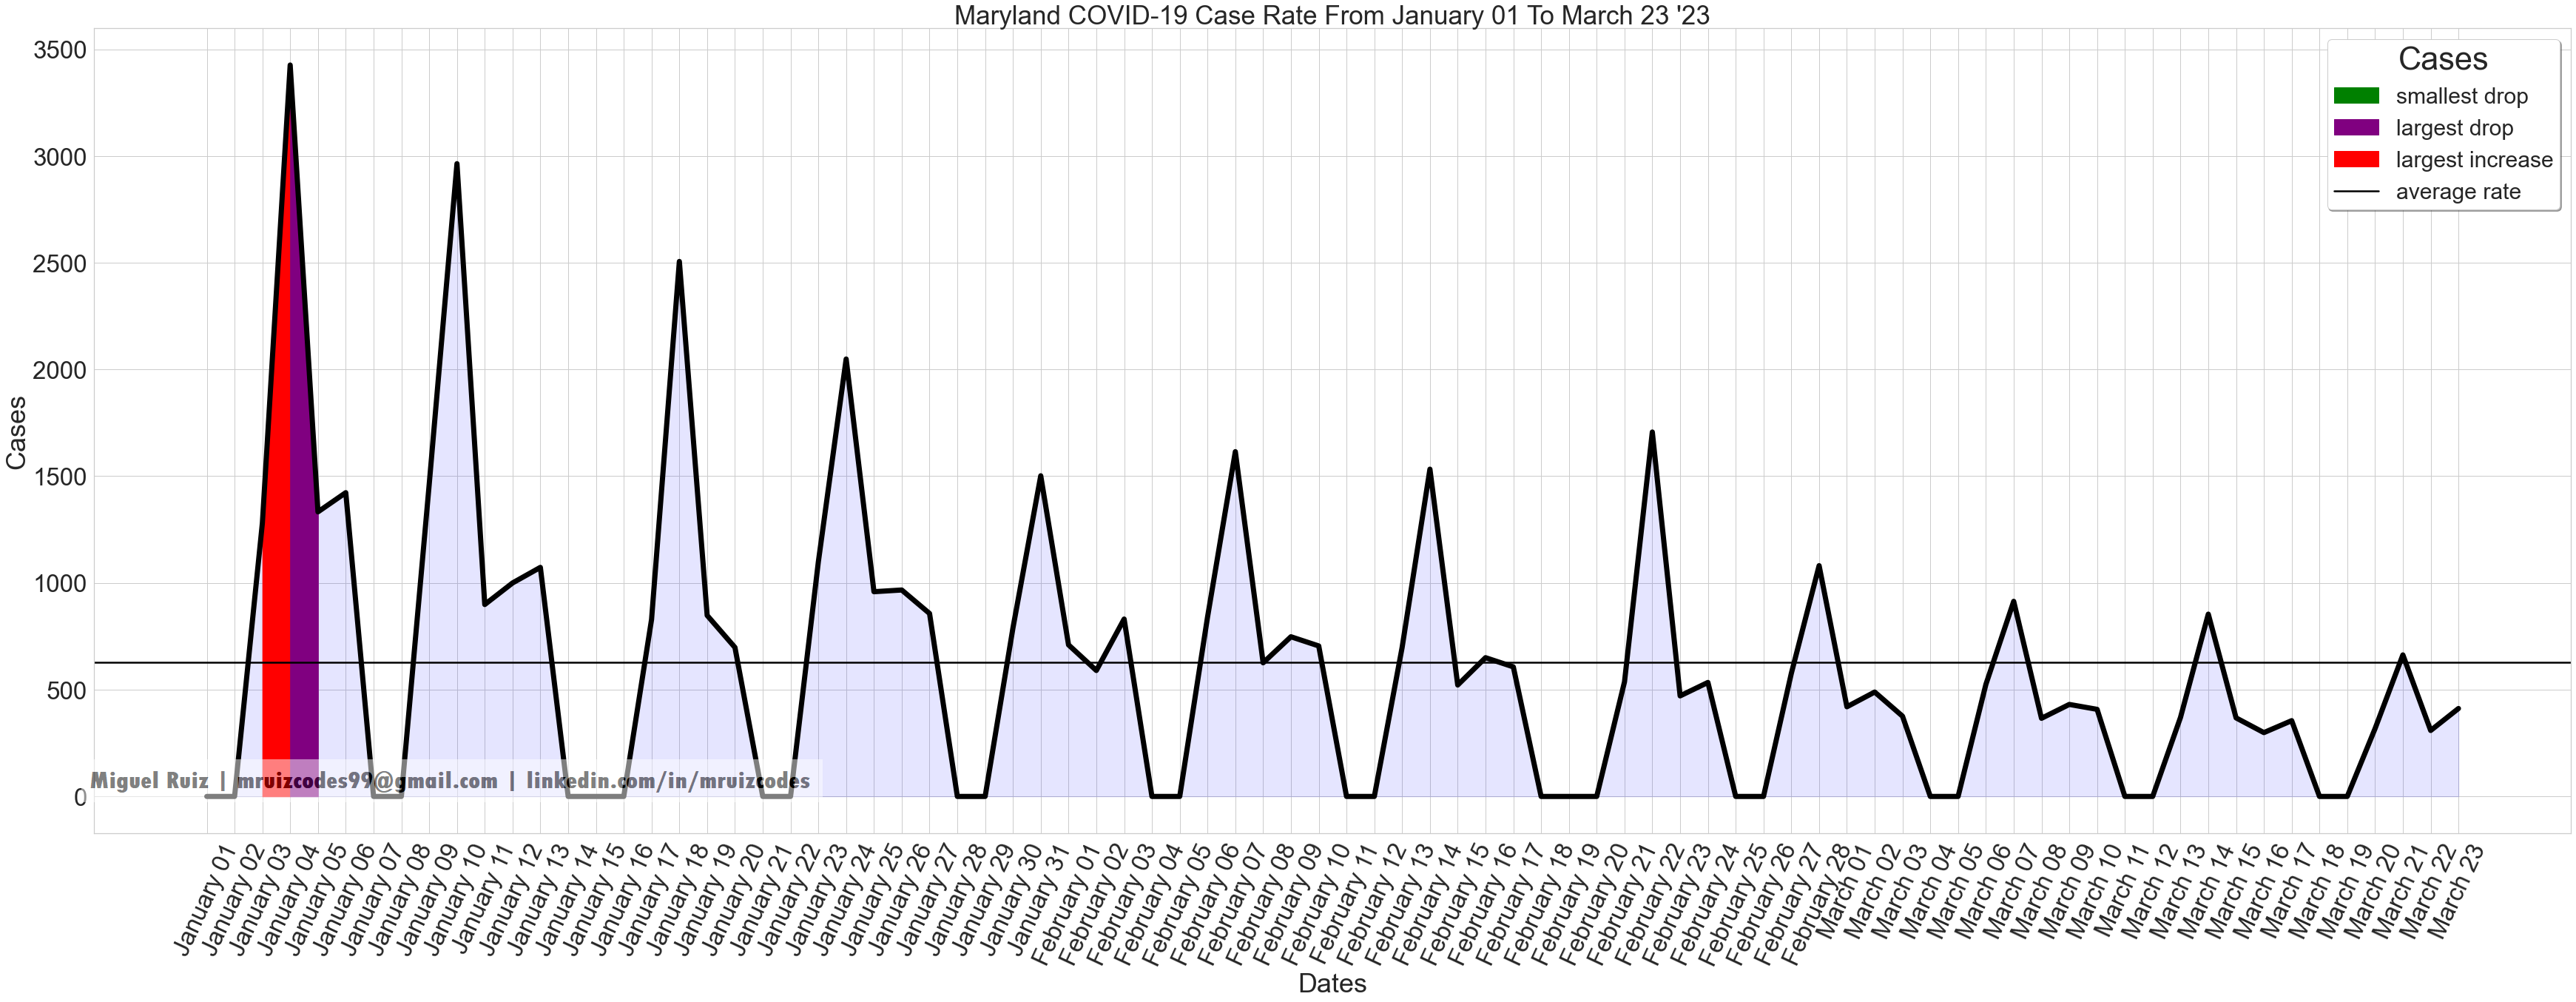


Maryland statistics from January 01 to March 23 '23.
Lowest recorded deaths:  -1 on March 15 '23
Highest recorded deaths:  50 on February 28 '23
A total of 638 deaths over the last 82 day(s).
Average death rate:  7.78 per day.
Largest increase in deaths:  47.0.
Smallest drop in deaths: 0.0.
Largest drop in deaths: 39.0


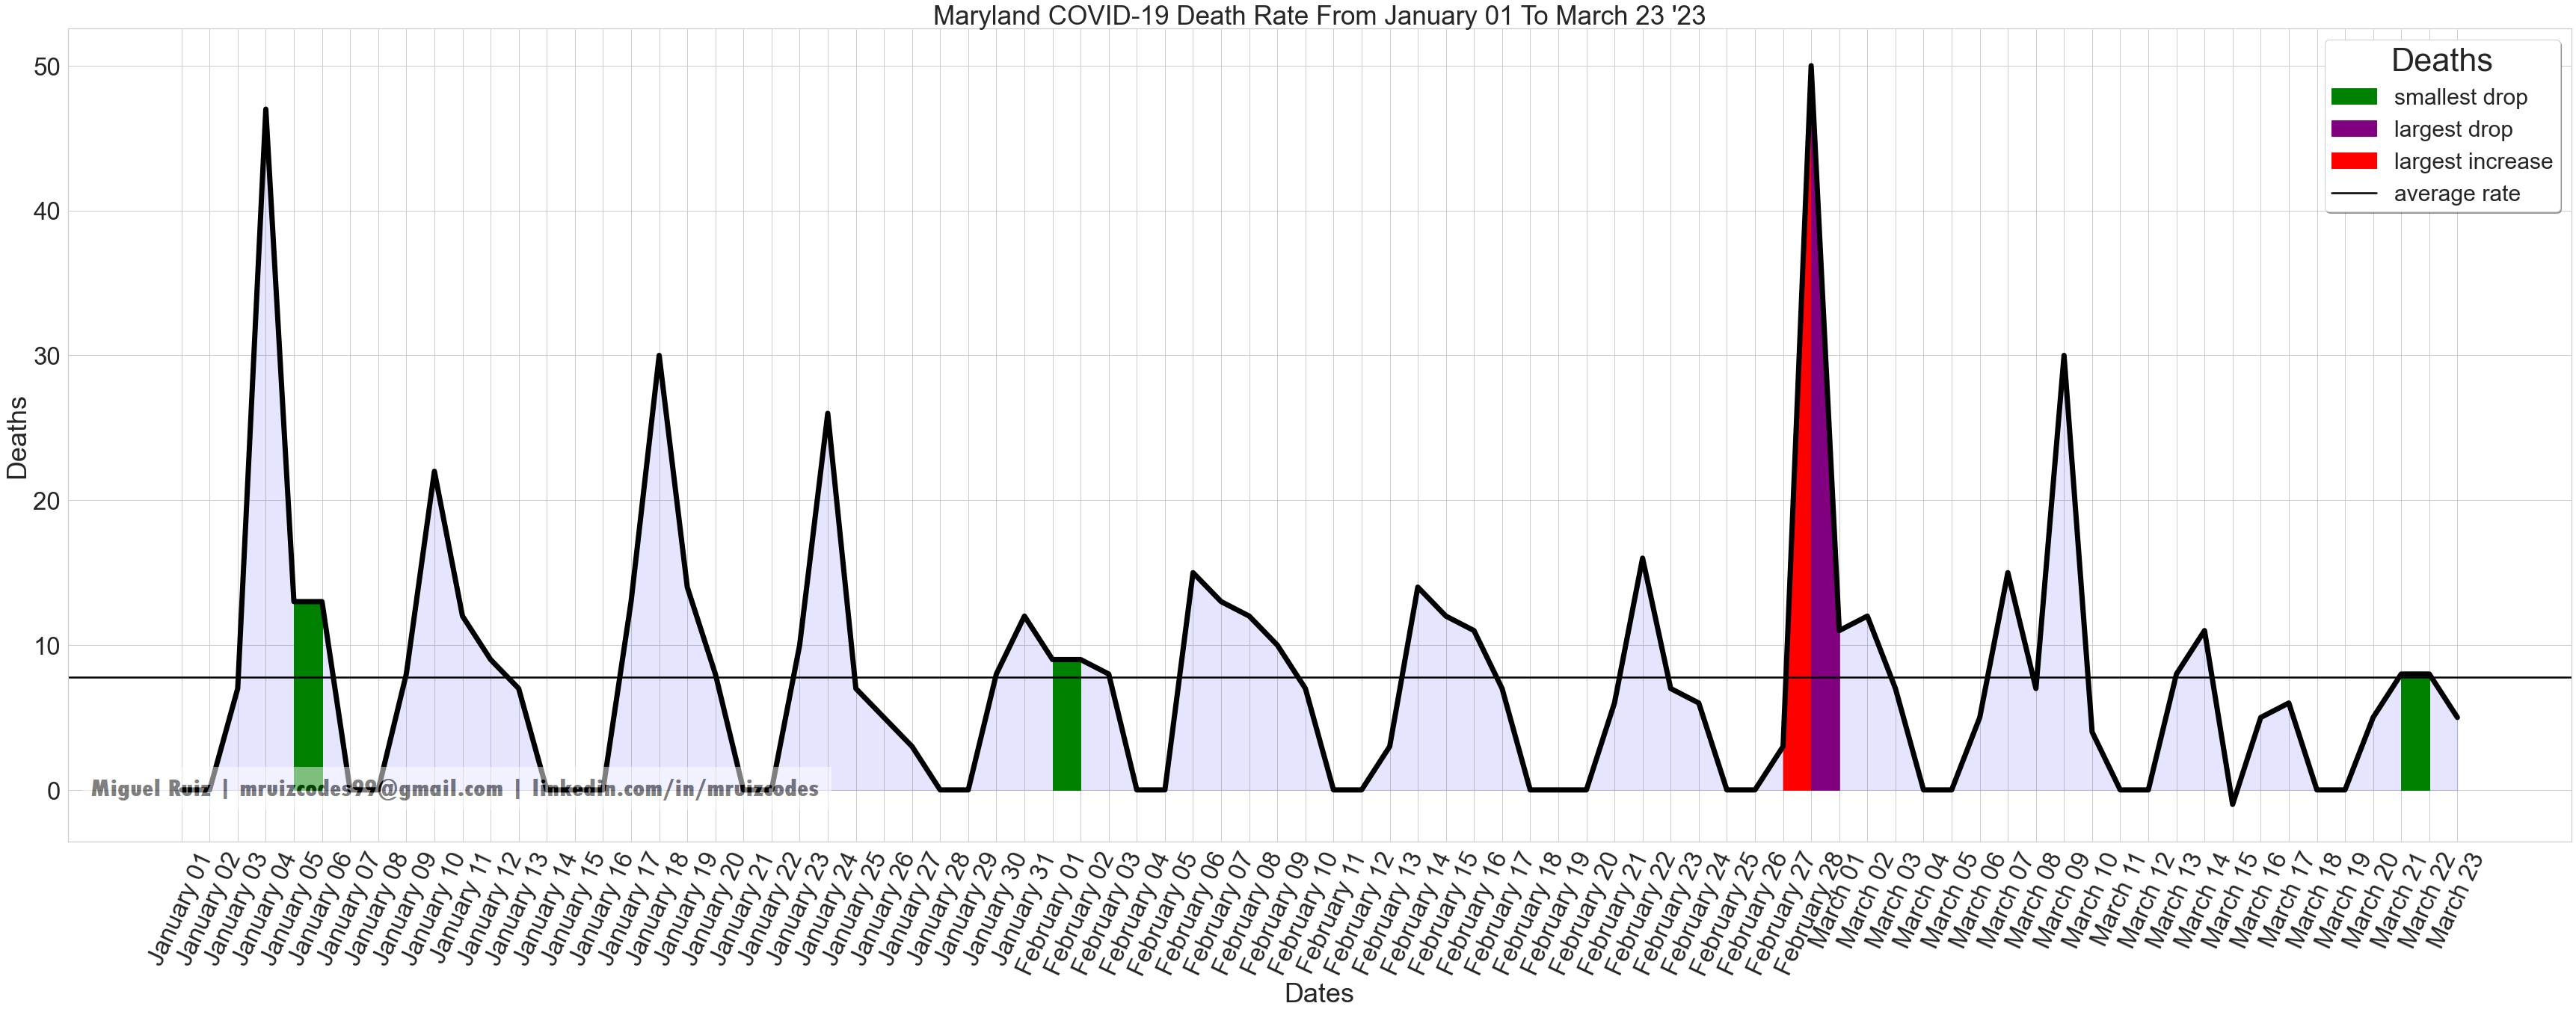

In [28]:
graphs = Graph(stats.allstats)
graphs.getGraph("info")

In [167]:
test = pd.read_csv('../../../documents/github/covid-19-data/us-counties.csv')
test2 = pd.read_csv('../../../documents/github/covid-19-data/us-counties-2022.csv')
finalTest = pd.concat([test[test['date'] < '2022-01-01'], test2])

In [168]:
finalTest = finalTest[finalTest['state']=="Maryland"]
finalTest.loc[:,'year'] = finalTest['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y'))
finalTest.loc[:,'day'] = finalTest['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))

In [169]:
finalTest

,date,county,state,fips,cases,deaths,year,day
555,2020-03-05,Montgomery,Maryland,24031.0,3,0.0,2020,05
615,2020-03-06,Montgomery,Maryland,24031.0,3,0.0,2020,06
700,2020-03-07,Montgomery,Maryland,24031.0,3,0.0,2020,07
801,2020-03-08,Harford,Maryland,24025.0,1,0.0,2020,08
802,2020-03-08,Montgomery,Maryland,24031.0,4,0.0,2020,08
...,...,...,...,...,...,...,...,...
736841,2022-08-15,Talbot,Maryland,24041.0,6367,92.0,2022,15
736842,2022-08-15,Unknown,Maryland,NaN,0,31.0,2022,15
736843,2022-08-15,Washington,Maryland,24043.0,37961,600.0,2022,15
736844,2022-08-15,Wicomico,Maryland,24045.0,22242,341.0,2022,15


In [180]:
finalTest[(finalTest['year'] == "2021") & (finalTest['county'] == "Prince George's")]

,date,county,state,fips,cases,deaths,year,day
885955,2021-01-01,Prince George's,Maryland,24033.0,55166,1089.0,2021,01
889201,2021-01-02,Prince George's,Maryland,24033.0,55721,1096.0,2021,02
892447,2021-01-03,Prince George's,Maryland,24033.0,56055,1097.0,2021,03
895694,2021-01-04,Prince George's,Maryland,24033.0,56418,1100.0,2021,04
898939,2021-01-05,Prince George's,Maryland,24033.0,56840,1101.0,2021,05
...,...,...,...,...,...,...,...,...
2055081,2021-12-27,Prince George's,Maryland,24033.0,102695,1759.0,2021,27
2058330,2021-12-28,Prince George's,Maryland,24033.0,119509,1778.0,2021,28
2061579,2021-12-29,Prince George's,Maryland,24033.0,121445,1781.0,2021,29
2064829,2021-12-30,Prince George's,Maryland,24033.0,124049,1786.0,2021,30
